In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

%matplotlib inline

/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [3]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

In [4]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['cat', 'dog', 'cat', 'dog', 'dog'] [0 1 0 1 1]


In [5]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [6]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.topology.InputLayer object at 0x7f26c86b2518>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f277c9fc080>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f26c86b26d8>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f26c86e6c88>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f26c867dc18>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f26c8690f28>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f26c869e5c0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f26c863f828>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f26c863f128>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f26c86607b8>,block3_conv3,False


In [7]:
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: []


(1, 4, 4, 512)


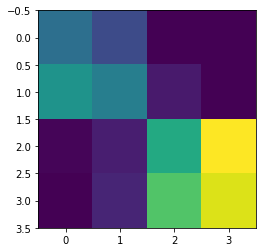

In [8]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [9]:
def get_bottleneck_features(model, input_imgs):
    
    features = model.predict(input_imgs, verbose=0)
    return features

In [10]:
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1000, 8192)


In [11]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 4,457,985
Trainable params: 4,457,985
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 1s 373us/step - loss: 0.4325 - acc: 0.7897 - val_loss: 0.2958 - val_acc: 0.8730
Epoch 2/30
3000/3000 [==============================] - 1s 286us/step - loss: 0.2857 - acc: 0.8783 - val_loss: 0.3294 - val_acc: 0.8530
Epoch 3/30
3000/3000 [==============================] - 1s 289us/step - loss: 0.2353 - acc: 0.9043 - val_loss: 0.2708 - val_acc: 0.8700
Epoch 4/30
3000/3000 [==============================] - 1s 286us/step - loss: 0.2059 - acc: 0.9133 - val_loss: 0.2651 - val_acc: 0.9050
Epoch 5/30
3000/3000 [==============================] - 1s 284us/step - loss: 0.1708 - acc: 0.9347 - val_loss: 0.2699 - val_acc: 0.8900
Epoch 6/30
3000/3000 [==============================] - 1s 286us/step - loss: 0.1486 - acc: 0.9363 - val_loss: 0.2632 - val_acc: 0.8980
Epoch 7/30
3000/3000 [==============================] - 1s 286us/step - loss: 0.1252 - acc: 0.9503 - val_loss: 0.2768 - val_acc: 0.8960


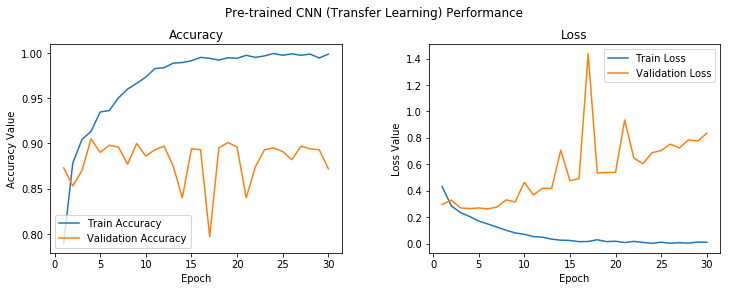

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [14]:
model.save('cats_dogs_tlearn_basic_cnn.h5')

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [16]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 4,457,985
Non-trainable params: 14,714,688
________________________________________________________

In [17]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/100
100/100 [==============================] - 45s 449ms/step - loss: 0.6511 - acc: 0.6153 - val_loss: 0.5147 - val_acc: 0.7840
Epoch 2/100
100/100 [==============================] - 41s 414ms/step - loss: 0.5651 - acc: 0.7110 - val_loss: 0.4249 - val_acc: 0.8180
Epoch 3/100
100/100 [==============================] - 41s 415ms/step - loss: 0.5069 - acc: 0.7527 - val_loss: 0.3790 - val_acc: 0.8260
Epoch 4/100
100/100 [==============================] - 42s 416ms/step - loss: 0.4803 - acc: 0.7717 - val_loss: 0.3569 - val_acc: 0.8410
Epoch 5/100
100/100 [==============================] - 42s 416ms/step - loss: 0.4491 - acc: 0.7897 - val_loss: 0.3427 - val_acc: 0.8400
Epoch 6/100
100/100 [==============================] - 42s 417ms/step - loss: 0.4201 - acc: 0.8027 - val_loss: 0.3238 - val_acc: 0.8470
Epoch 7/100
100/100 [==============================] - 42s 417ms/step - loss: 0.4193 - acc: 0.8070 - val_loss: 0.3092 - val_acc: 0.8620
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 42s 419ms/step - loss: 0.2994 - acc: 0.8717 - val_loss: 0.2770 - val_acc: 0.8860
Epoch 62/100
100/100 [==============================] - 42s 419ms/step - loss: 0.2866 - acc: 0.8827 - val_loss: 0.2690 - val_acc: 0.9020
Epoch 63/100
100/100 [==============================] - 42s 419ms/step - loss: 0.3042 - acc: 0.8680 - val_loss: 0.2630 - val_acc: 0.9040
Epoch 64/100
100/100 [==============================] - 42s 419ms/step - loss: 0.2919 - acc: 0.8683 - val_loss: 0.2680 - val_acc: 0.9040
Epoch 65/100
100/100 [==============================] - 42s 419ms/step - loss: 0.2938 - acc: 0.8690 - val_loss: 0.2651 - val_acc: 0.9020
Epoch 66/100
100/100 [==============================] - 42s 419ms/step - loss: 0.2983 - acc: 0.8723 - val_loss: 0.2744 - val_acc: 0.8910
Epoch 67/100
100/100 [==============================] - 42s 419ms/step - loss: 0.2848 - acc: 0.8797 - val_loss: 0.2730 - val_acc: 0.8950
Epoch 68/100
100/100 [===================

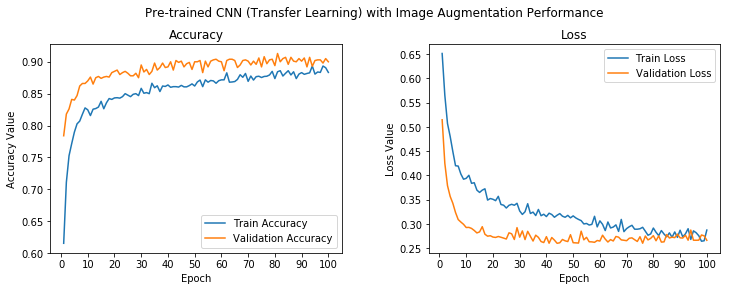

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [19]:
model.save('cats_dogs_tlearn_img_aug_cnn.h5')

In [20]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: [<tf.Variable 'block4_conv1/kernel:0' shape=(3, 3, 256, 512) dtype=float32_ref>, <tf.Variable 'block4_conv1/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'block4_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>, <tf.Variable 'block4_conv2/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'block4_conv3/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>, <tf.Variable 'block4_conv3/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'block5_conv1/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>, <tf.Variable 'block5_conv1/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'block5_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>, <tf.Variable 'block5_conv2/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'block5_conv3/kernel:0' shape=(3, 3, 512, 512) dtype=float32_ref>, <tf.Variable 'block5_conv3/bias:0' shape=(512,) dtype=float32_ref>]


In [21]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.topology.InputLayer object at 0x7f26c86b2518>,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0x7f277c9fc080>,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0x7f26c86b26d8>,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0x7f26c86e6c88>,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0x7f26c867dc18>,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0x7f26c8690f28>,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7f26c869e5c0>,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0x7f26c863f828>,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0x7f26c863f128>,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0x7f26c86607b8>,block3_conv3,False


In [22]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [23]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 8192)              14714688  
_________________________________________________________________
dense_7 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
________________________________________________________

In [24]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, verbose=1)

Epoch 1/100
100/100 [==============================] - 64s 642ms/step - loss: 0.6070 - acc: 0.6547 - val_loss: 0.4029 - val_acc: 0.8250
Epoch 2/100
100/100 [==============================] - 63s 630ms/step - loss: 0.3976 - acc: 0.8103 - val_loss: 0.2273 - val_acc: 0.9030
Epoch 3/100
100/100 [==============================] - 63s 631ms/step - loss: 0.3440 - acc: 0.8530 - val_loss: 0.2221 - val_acc: 0.9150
Epoch 4/100
100/100 [==============================] - 63s 630ms/step - loss: 0.2948 - acc: 0.8773 - val_loss: 0.2226 - val_acc: 0.9170
Epoch 5/100
100/100 [==============================] - 63s 631ms/step - loss: 0.2514 - acc: 0.8933 - val_loss: 0.1539 - val_acc: 0.9440
Epoch 6/100
100/100 [==============================] - 63s 630ms/step - loss: 0.2396 - acc: 0.8980 - val_loss: 0.2022 - val_acc: 0.9290
Epoch 7/100
100/100 [==============================] - 63s 631ms/step - loss: 0.2209 - acc: 0.9107 - val_loss: 0.1316 - val_acc: 0.9460
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 63s 629ms/step - loss: 0.0345 - acc: 0.9897 - val_loss: 0.1929 - val_acc: 0.9650
Epoch 62/100
100/100 [==============================] - 63s 628ms/step - loss: 0.0435 - acc: 0.9860 - val_loss: 0.1807 - val_acc: 0.9630
Epoch 63/100
100/100 [==============================] - 63s 627ms/step - loss: 0.0362 - acc: 0.9860 - val_loss: 0.2241 - val_acc: 0.9560
Epoch 64/100
100/100 [==============================] - 63s 629ms/step - loss: 0.0268 - acc: 0.9923 - val_loss: 0.1873 - val_acc: 0.9630
Epoch 65/100
100/100 [==============================] - 63s 628ms/step - loss: 0.0359 - acc: 0.9893 - val_loss: 0.1920 - val_acc: 0.9640
Epoch 66/100
100/100 [==============================] - 63s 627ms/step - loss: 0.0338 - acc: 0.9867 - val_loss: 0.2174 - val_acc: 0.9610
Epoch 67/100
100/100 [==============================] - 63s 629ms/step - loss: 0.0397 - acc: 0.9873 - val_loss: 0.1981 - val_acc: 0.9620
Epoch 68/100
100/100 [===================

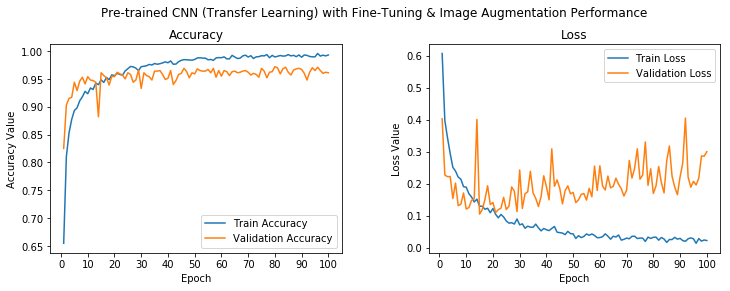

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning & Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [26]:
model.save('cats_dogs_tlearn_finetune_img_aug_cnn.h5')